# Import libs

In [20]:
# region Data Libraries
import pandas as pd
import geopandas as gpd
import numpy as np
# endregion

# region Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# endregion

# region Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import contextily as ctx
import folium
from folium.plugins import MarkerCluster
# endregion

# region Fuzzy Matching
from thefuzz import fuzz, process
from rapidfuzz import fuzz
# endregion

# region Date and Time
import datetime
from datetime import datetime
# endregion

# region Utilities
import re
from collections import Counter, defaultdict
import importlib
# endregion

import joblib

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE

import shap
import fiona

from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import numpy as np

import numpy as np
import pandas as pd
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt




# Recreate 200m buffer and 400m buffer

In [3]:
import pandas as pd
import geopandas as gpd

# -- Region: Load and Prepare Accident Data (2017–2020) --

accident_cols = ['VKL_NUMMER', 'JAAR_VKL', 'AP3_CODE', 'ANTL_PTJ', 'AOL_ID', 'NIVEAUKOP', 'WSE_ID',
                 'BEBKOM', 'MAXSNELHD', 'WVL_ID', 'WVG_ID', 'WVG_AN', 'WDK_ID', 'LGD_ID', 'WGD_CODE_1',
                 'WGD_CODE_2', 'BZD_ID_VM1', 'BZD_ID_IF1', 'BZD_IF_AN', 'BZD_ID_TA1', 'BZD_TA_AN',
                 'JTE_ID', 'WVK_ID', 'FK_VELD5', 'GME_ID', 'GME_NAAM', 'PVE_CODE', 'PVE_NAAM']

# Read accident data for 2017–2020
accidents = {}
for year in range(2017, 2021):
    path = f"/Users/jorissoolsma/Downloads/01-01-{year}_31-12-{year}/Ongevallengegevens/ongevallen.txt"
    accidents[year] = pd.read_csv(path, sep=',', encoding='latin1', usecols=accident_cols)

# Read location data for 2017–2020
locations = {}
for year in range(2017, 2021):
    path = f"/Users/jorissoolsma/Downloads/01-01-{year}_31-12-{year}/Netwerkgegevens/puntlocaties.txt"
    df = pd.read_csv(path)
    locations[year] = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['X_COORD'], df['Y_COORD']), crs="EPSG:28992")

# Merge accidents with location data
merged = {year: accidents[year].merge(locations[year], on='FK_VELD5') for year in range(2017, 2021)}

# -- Region: Load and Prepare 2021–2023 Data --
print('X')
def load_recent_year(year):
    location_path = f"/Users/jorissoolsma/Desktop/Programming/Datasets/BRON Puntlocatie's/puntlocaties{year}.txt"
    accident_path = f"/Users/jorissoolsma/Desktop/Programming/Datasets/BRON Ongevallen/ongevallen{year}.txt"
    
    df_loca = pd.read_csv(location_path)
    gdf_loca = gpd.GeoDataFrame(df_loca, geometry=gpd.points_from_xy(df_loca['X_COORD'], df_loca['Y_COORD']), crs="EPSG:28992")
    
    df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)
    merged = df_acc.merge(gdf_loca, on='FK_VELD5')
    return merged

merged[2021] = load_recent_year(2021)
merged[2022] = load_recent_year(2022)
merged[2023] = load_recent_year(2023)

# -- Region: Combine All Years --

# Combine all years into one dataframe
all_accidents = pd.concat(list(merged.values()), ignore_index=True)

# Preview output
all_accidents.info()


/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_96227/3908179532.py:15: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents[year] = pd.read_csv(path, sep=',', encoding='latin1', usecols=accident_cols)


X


/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_96227/3908179532.py:36: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)
/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_96227/3908179532.py:36: DtypeWarning: Columns (29,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df_acc = pd.read_csv(accident_path, sep=',', encoding='latin1', usecols=accident_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860610 entries, 0 to 860609
Data columns (total 31 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   VKL_NUMMER  860610 non-null  int64   
 1   JAAR_VKL    860610 non-null  int64   
 2   AP3_CODE    860610 non-null  object  
 3   ANTL_PTJ    860610 non-null  int64   
 4   AOL_ID      860610 non-null  int64   
 5   NIVEAUKOP   860610 non-null  object  
 6   WSE_ID      556174 non-null  float64 
 7   BEBKOM      563350 non-null  object  
 8   MAXSNELHD   735232 non-null  float64 
 9   WVL_ID      554708 non-null  float64 
 10  WVG_ID      547828 non-null  float64 
 11  WVG_AN      4470 non-null    object  
 12  WDK_ID      560018 non-null  float64 
 13  LGD_ID      860598 non-null  float64 
 14  WGD_CODE_1  540987 non-null  object  
 15  WGD_CODE_2  751 non-null     object  
 16  BZD_ID_VM1  46931 non-null   float64 
 17  BZD_ID_IF1  29389 non-null   float64 
 18  BZD_IF_AN   64042 non-nu

# Time

In [4]:
# -- Step 1: Define column types and load CSV --
types = {
    'VKL_NUMMER': 'Int64',
    'DATUM_VKL': 'Int64',
    'UUR': 'object'
}

time = pd.read_csv('/Users/jorissoolsma/Desktop/Programming/Datasets/BRON time/Export_datumVKL_Uur.txt', dtype=types, na_values=None)

# -- Step 2: Fix hour formatting (pad with leading zero if needed) --
time['UUR'] = time['UUR'].apply(lambda x: f'{x:02}')

# -- Step 3: Combine date and hour into single datetime string --
time['DATUM_VKL'] = time['DATUM_VKL'].astype(str) + time['UUR']

# -- Step 4: Convert to datetime format safely --
time['DATUM_VKL'] = pd.to_datetime(time['DATUM_VKL'], format='%Y%m%d%H', errors='coerce')

# -- Step 5: Drop raw hour column --
time = time.drop(columns='UUR')

# -- Step 6: Extract datetime components --
time['Hour'] = time['DATUM_VKL'].dt.hour
time['Month'] = time['DATUM_VKL'].dt.month
time['Day'] = time['DATUM_VKL'].dt.day
time['Day_of_week'] = time['DATUM_VKL'].dt.dayofweek


In [5]:

all_accidents = all_accidents.merge(time, left_on= 'VKL_NUMMER', right_on= 'VKL_NUMMER', how = 'left')

In [6]:
all_accidents = gpd.GeoDataFrame(all_accidents, geometry=gpd.points_from_xy(all_accidents['X_COORD'], all_accidents['Y_COORD']))  ### Adds a geometry column

all_accidents = all_accidents.set_crs('EPSG:28992')      # Ensures that CRS is set to the standard in the Netherlands
all_accidents.crs                                 # <Projected CRS: EPSG:28992>


<Projected CRS: EPSG:28992>
Name: Amersfoort / RD New
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Netherlands - onshore, including Waddenzee, Dutch Wadden Islands and 12-mile offshore coastal zone.
- bounds: (3.2, 50.75, 7.22, 53.7)
Coordinate Operation:
- name: RD New
- method: Oblique Stereographic
Datum: Amersfoort
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [7]:
# -- Create 200m buffer GeoDataFrame --
df_200m = all_accidents.copy()
df_200m['buffer_200m'] = df_200m.geometry.buffer(200)
df_200m = df_200m.set_geometry('buffer_200m')

# -- Create 400m buffer GeoDataFrame --
df_400m = all_accidents.copy()
df_400m['buffer_400m'] = df_400m.geometry.buffer(400)
df_400m = df_400m.set_geometry('buffer_400m')


# Location Accuracy

In [8]:
# Exclude accidents with non-exact x,y location (street and municipality)
location_accuracies = ['S', 'G']

# --- Filter 200m buffer ---
df_200m_filtered = df_200m[~df_200m['NIVEAUKOP'].isin(location_accuracies)].copy()



# --- Filter 400m buffer ---
df_400m_filtered = df_400m[~df_400m['NIVEAUKOP'].isin(location_accuracies)].copy()




# Rename

In [9]:
new_column_names = {
    'VKL_NUMMER':'Accident_Id',
    'JAAR_VKL':'Year',
    'AP3_CODE':'Severity_level',
    'ANTL_PTJ': 'Nr_of_parties',
    'AOL_ID': 'Nature_of_accident',
    'NIVEAUKOP':'Location_accuracy',
    'WSE_ID': 'Road_segment_type',
    'BEBKOM':'Urban_zone',
    'MAXSNELHD':'Max_speed',
    'WVL_ID': 'Streetlight_status',
    'WVG_ID': 'Road_surface',                           ### merge with road_surface_other
    'WVG_AN': 'Road_surface_other',                     ### merge with road_surface
    'WDK_ID': 'Road_surface_condition',
    'LGD_ID': 'Natural_light',
    'WGD_CODE_1' : 'Weather_conditions_1',              ### check whether these are not the same
    'WGD_CODE_2' : 'Weather_conditions_2',              ### check whether these are not the same
    'BZD_ID_VM1' : 'Special_traffic_measure',           
    'BZD_ID_IF1' : 'Special_infrastructure',
    'BZD_IF_AN' : 'Special_infrastructure_other',       ### needs additional preprocessing
    'BZD_ID_TA1' : 'Special_temporary',
    'BZD_TA_AN' : 'Special_temporary_other',            ### needs addiitonal preprocessing, some can be used to fill features
    'JTE_ID_X': 'Junction_Id',
    'WVK_ID_X': 'Road_section_Id',
    'FK_VELD5': 'Location_id',
    'GME_ID' : 'Municipality_Id',
    'GME_NAAM': 'Municipality_name',
    'PVE_CODE' : 'Province_Id',
    'PVE_NAAM' : 'Province_name',
}

df_200m_filtered = df_200m_filtered.rename(columns=new_column_names)
df_400m_filtered = df_400m_filtered.rename(columns=new_column_names)

# Read & Merge BAG

In [10]:
import geopandas as gpd
import pandas as pd

# Load BAG data
bag_path = '/Users/jorissoolsma/Desktop/Programming/Datasets/BAG/bag-light.gpkg 2'
bag = gpd.read_file(bag_path, layer='pand')[['bouwjaar', 'gebruiksdoel', 'geometry']]

# Convert polygons to centroids
bag['geometry'] = bag.geometry.centroid

# Remove invalid years
bag = bag[bag['bouwjaar'] != 9999]

# Simplify gebruiksdoel
def simplify_gebruiksdoel(value):
    if pd.isna(value):
        return value
    if ',' in value:
        return 'mixed_usage'
    return value

bag['gebruiksdoel_simplified'] = bag['gebruiksdoel'].apply(simplify_gebruiksdoel)
bag = bag.drop(columns='gebruiksdoel')


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /Users/jorissoolsma/Desktop/Programming/Datasets/BAG/bag-light.gpkg 2 has GPKG application_id, but non conformant file extension
  return ogr_read(


In [11]:
def process_buffer_batches(buffers_gdf, points_gdf, buffer_col, batch_size=100, total=None):
    """
    Joins BAG points to buffer polygons in batches and aggregates counts of 'gebruiksdoel_simplified'.

    Parameters:
        buffers_gdf (GeoDataFrame): GeoDataFrame with buffer geometry (e.g., 'buffer_200m').
        points_gdf (GeoDataFrame): BAG data with 'gebruiksdoel_simplified' and point geometry.
        buffer_col (str): Name of the buffer geometry column to use.
        batch_size (int): Number of buffers per batch.
        total (int): Total number of buffers to process (optional).

    Returns:
        pd.DataFrame: Aggregated counts of usage types per buffer.
    """
    if total is None:
        total = len(buffers_gdf)

    results = []

    for start in range(0, total, batch_size):
        end = min(start + batch_size, total)
        print(f"Processing batch {start} to {end - 1}...")

        batch = buffers_gdf.iloc[start:end].copy()
        batch = batch.set_geometry(buffer_col)

        joined = gpd.sjoin(points_gdf, batch, how='inner', predicate='within')

        agg = (
            joined.groupby(['Accident_Id', 'gebruiksdoel_simplified'])
            .size()
            .unstack(fill_value=0)
            .add_suffix(f'_count_{buffer_col[-4:]}')
            .reset_index()
        )

        results.append(agg)

    return pd.concat(results, ignore_index=True)


In [12]:
# Prepare buffer GeoDataFrames
bron_buffer_200m = df_200m_filtered[['Accident_Id', 'buffer_200m']].copy()
bron_buffer_400m = df_400m_filtered[['Accident_Id', 'buffer_400m']].copy()

# Run aggregation
result_200m = process_buffer_batches(
    buffers_gdf=bron_buffer_200m,
    points_gdf=bag,
    buffer_col='buffer_200m',
    batch_size=100000,
    total=bron_buffer_200m.shape[0]
)

result_400m = process_buffer_batches(
    buffers_gdf=bron_buffer_400m,
    points_gdf=bag,
    buffer_col='buffer_400m',
    batch_size=100000,
    total=bron_buffer_400m.shape[0]
)

Processing batch 0 to 99999...
Processing batch 100000 to 199999...
Processing batch 200000 to 299999...
Processing batch 300000 to 399999...
Processing batch 400000 to 499999...
Processing batch 500000 to 599999...
Processing batch 600000 to 699999...
Processing batch 700000 to 724110...
Processing batch 0 to 99999...
Processing batch 100000 to 199999...
Processing batch 200000 to 299999...
Processing batch 300000 to 399999...
Processing batch 400000 to 499999...
Processing batch 500000 to 599999...
Processing batch 600000 to 699999...
Processing batch 700000 to 724110...


In [13]:
column_translation = {
    "bijeenkomstfunctie_count_100m": "assembly_function_count_100m",
    "celfunctie_count_100m": "detention_function_count_100m",  
    "gezondheidszorgfunctie_count_100m": "healthcare_function_count_100m",
    "industriefunctie_count_100m": "industrial_function_count_100m",
    "kantoorfunctie_count_100m": "office_function_count_100m",
    "logiesfunctie_count_100m": "lodging_function_count_100m",
    "mixed_usage_count_100m": "mixed_usage_count_100m",
    "onderwijsfunctie_count_100m": "educational_function_count_100m",
    "overige gebruiksfunctie_count_100m": "other_usage_function_count_100m",
    "sportfunctie_count_100m": "sports_function_count_100m",
    "winkelfunctie_count_100m": "retail_function_count_100m",
    "woonfunctie_count_100m": "residential_function_count_100m"
}

column_translation_200m = {k.replace("100m", "200m"): v.replace("100m", "200m") for k, v in column_translation.items()}
column_translation_400m = {k.replace("100m", "400m"): v.replace("100m", "400m") for k, v in column_translation.items()}

df_2 = result_200m.rename(columns=column_translation_200m)
df_4 = result_400m.rename(columns=column_translation_400m)


In [14]:
df_200m_merged = df_200m_filtered.merge(df_2, on='Accident_Id', how='left')
df_400m_merged = df_400m_filtered.merge(df_4, on='Accident_Id', how='left')

In [15]:
joblib.dump(df_200m_merged, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/df_200')
joblib.dump(df_400m_merged, '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/df_400')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/df_400']

### age buildings

In [16]:
from datetime import datetime
import geopandas as gpd

def average_bouwjaar_age(buffers_gdf, points_gdf, buffer_col='buffer_100m'):
    """
    Computes the average age of buildings (based on bouwjaar) per buffer polygon.

    Parameters:
        buffers_gdf (GeoDataFrame): Contains 'Accident_Id' and buffer column (e.g. 'buffer_200m').
        points_gdf (GeoDataFrame): Contains building points with 'bouwjaar' column.
        buffer_col (str): Name of the buffer geometry column to use.

    Returns:
        pd.DataFrame: Columns: ['Accident_Id', 'average_age']
    """
    # Ensure both layers are in same Dutch CRS
    buffers_gdf = buffers_gdf.to_crs(epsg=28992)
    points_gdf = points_gdf.to_crs(epsg=28992)

    # Set the active geometry to the buffer
    buffers = buffers_gdf.set_geometry(buffer_col)

    # Spatial join: buildings within buffer
    joined = gpd.sjoin(points_gdf, buffers, how='inner', predicate='within')

    # Calculate building age
    current_year = datetime.now().year
    joined['age'] = current_year - joined['bouwjaar']

    # Filter out unreasonable ages
    joined = joined[(joined['age'] > 0) & (joined['age'] < 200)]

    # Average age per accident
    avg_age = joined.groupby('Accident_Id')['age'].mean().reset_index()
    avg_age = avg_age.rename(columns={'age': 'average_age'})

    return avg_age


In [20]:
avg_age_200m = average_bouwjaar_age(bron_buffer_200m, bag, buffer_col='buffer_200m')



In [22]:
avg_age_400m = average_bouwjaar_age(bron_buffer_400m, bag, buffer_col='buffer_400m')

In [23]:
df_200_post_bag =  df_200m_merged.merge(avg_age_200m, on= 'Accident_Id', how = 'left')

In [25]:
df_400_post_bag =  df_400m_merged.merge(avg_age_400m, on= 'Accident_Id', how = 'left')

In [26]:
df_400_post_bag

,Accident_Id,Year,Severity_level,Nr_of_parties,Nature_of_accident,Location_accuracy,Road_segment_type,Urban_zone,Max_speed,Streetlight_status,...,industrial_function_count_400m,office_function_count_400m,lodging_function_count_400m,mixed_usage_count_400m,educational_function_count_400m,other_usage_function_count_400m,sports_function_count_400m,retail_function_count_400m,residential_function_count_400m,average_age
0,20170096239,2017,UMS,2,7,E,5.0,BI,50.0,2.0,...,0.0,2.0,1.0,44.0,1.0,21.0,1.0,2.0,945.0,75.621139
1,20170096245,2017,LET,2,7,E,5.0,BI,30.0,2.0,...,2.0,1.0,0.0,9.0,1.0,3.0,0.0,4.0,323.0,44.614187
2,20170096247,2017,LET,2,6,E,4.0,BI,30.0,2.0,...,2.0,0.0,0.0,33.0,1.0,131.0,2.0,2.0,946.0,53.493652
3,20170096274,2017,UMS,4,8,E,1.0,BU,100.0,2.0,...,0.0,10.0,0.0,1.0,0.0,6.0,0.0,0.0,318.0,45.203338
4,20170096276,2017,UMS,2,7,E,5.0,BI,50.0,1.0,...,3.0,0.0,0.0,11.0,6.0,22.0,2.0,0.0,215.0,55.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724106,20230090445,2023,LET,2,9,E,1.0,BI,50.0,2.0,...,24.0,1.0,0.0,13.0,0.0,3.0,1.0,0.0,30.0,37.116505
724107,20230090446,2023,UMS,2,7,E,5.0,BU,70.0,1.0,...,20.0,2.0,0.0,6.0,1.0,2.0,0.0,0.0,25.0,40.390805
724108,20230090447,2023,UMS,2,7,K,4.0,BI,50.0,2.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,44.0,45.710744
724109,20230090450,2023,LET,2,7,E,4.0,BI,15.0,3.0,...,7.0,6.0,0.0,70.0,4.0,26.0,1.0,25.0,874.0,59.816878


In [27]:
joblib.dump((df_200_post_bag, df_400_post_bag), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/df200_df400_post_avgage')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/df200_df400_post_avgage']

# wegvakken

In [68]:
wegvakken = pd.read_csv('/Users/jorissoolsma/Desktop/BRON_2022/Netwerkgegevens/wegvakken.txt', usecols= ['WVK_ID','BST_CODE'])

In [91]:
post_wegvak_200 = df_200_post_bag.merge(wegvakken, on = 'WVK_ID', how = 'left')
post_wegvak_400 = df_400_post_bag.merge(wegvakken, on = 'WVK_ID', how = 'left')


# Road categories

In [92]:
road_category = pd.read_csv('/Users/jorissoolsma/Desktop/Programming/Datasets/Wegcategorien/wkd_011-WEG_CAT.csv', sep = ';', usecols= ['WEGVAK_ID','WEG_CAT'])

In [94]:
post_road_cat_200 = post_wegvak_200.merge(road_category, left_on= 'WVK_ID', right_on= 'WEGVAK_ID', how= 'left').drop(columns='WEGVAK_ID')
post_road_cat_400 = post_wegvak_400.merge(road_category, left_on= 'WVK_ID', right_on= 'WEGVAK_ID', how= 'left').drop(columns='WEGVAK_ID')


In [95]:
post_road_cat_200 = post_road_cat_200.drop_duplicates(subset= 'Accident_Id', keep= 'first')
post_road_cat_400 = post_road_cat_400.drop_duplicates(subset= 'Accident_Id', keep= 'first')


# rudifun

In [89]:
# Read GeoDatabase
gdb_path = "/Users/jorissoolsma/Downloads/Rudifun_NL_v2022_fgdb/Rudifun_v2022.gdb"

# rudifun = gpd.read_file(gdb_path, layer='Rudifun_1_Netto_Bouwblok')

rudifun = gpd.read_file(gdb_path, layer='Rudifun_1_Netto_Bouwblok', columns=['FSI_22', 'GSI_22','OSR_22', 'L_22', 'MXI_22', 'geometry'])

#Drop data from the years 2015
rudifun = rudifun[[col for col in rudifun.columns if not col.endswith("_15")]]

/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts.  The processing may be really slow.  You can skip the processing by setting METHOD=SKIP.
  return ogr_read(


In [126]:
# subset accidents
non_highway_accidents_200 = post_road_cat_200[post_road_cat_200['WEG_CAT'] != 'autosnelweg']
non_highway_accidents_400 = post_road_cat_400[post_road_cat_400['WEG_CAT'] != 'autosnelweg']
non_highway_accidents_200 = non_highway_accidents_200.set_geometry('buffer_200m')
non_highway_accidents_400 = non_highway_accidents_400.set_geometry('buffer_400m')

In [106]:
# intersect buffer with environment
intersection_200 = non_highway_accidents_200.sjoin(rudifun, how = 'left', predicate= 'intersects')
intersection_400 = non_highway_accidents_400.sjoin(rudifun, how = 'left', predicate= 'intersects')

In [108]:
agg_stats_200 = intersection_200.groupby('Accident_Id').agg({
    'FSI_22': ['mean', 'std', 'min', 'max'],
    'GSI_22': ['mean', 'std', 'min', 'max'],
    'OSR_22': ['mean', 'std', 'min', 'max'],
    'L_22':   ['mean', 'std', 'min', 'max'],
    'MXI_22': ['mean', 'std', 'min', 'max']
})

agg_stats_200.columns = [f"{col[0]}_{col[1]}" for col in agg_stats_200.columns]
agg_stats_200 = agg_stats_200.reset_index()

In [109]:
agg_stats_400 = intersection_400.groupby('Accident_Id').agg({
    'FSI_22': ['mean', 'std', 'min', 'max'],
    'GSI_22': ['mean', 'std', 'min', 'max'],
    'OSR_22': ['mean', 'std', 'min', 'max'],
    'L_22':   ['mean', 'std', 'min', 'max'],
    'MXI_22': ['mean', 'std', 'min', 'max']
})

agg_stats_400.columns = [f"{col[0]}_{col[1]}" for col in agg_stats_400.columns]
agg_stats_400 = agg_stats_400.reset_index()

In [110]:
both_200 = non_highway_accidents_200.merge(agg_stats_200, on = 'Accident_Id', how = 'left')
both_400 = non_highway_accidents_400.merge(agg_stats_400, on = 'Accident_Id', how = 'left')

In [127]:
post_road_cat_200.shape

(724111, 52)

In [131]:
# Drop overlapping columns in 'both'
cols_to_add = both_200.columns.difference(post_road_cat_200.columns).tolist() + ['Accident_Id']

# Mrge  on the extra columns from 'both'
merged_200 = post_road_cat_200.merge(both_200[cols_to_add], 
                                     on='Accident_Id', how='left').set_index(post_road_cat_200.index)



cols_to_add = both_400.columns.difference(post_road_cat_400.columns).tolist() + ['Accident_Id']

# Mrge  on the extra columns from 'both'
merged_400 = post_road_cat_400.merge(both_400[cols_to_add], 
                                     on='Accident_Id', how='left').set_index(post_road_cat_400.index)


In [133]:
assert merged_200.index.equals(post_road_cat_400.index)

In [137]:
merged_200 = merged_200.set_geometry(col= 'geometry')
merged_400 = merged_400.set_geometry(col= 'geometry')

In [138]:
joblib.dump((merged_200, merged_400), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_rudifun200_400.pkl')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_rudifun200_400.pkl']

# cbs

In [142]:
cols = [
    'personenautos_per_huishouden', 'motortweewielers_totaal',
    'ziekenhuis_incl_buitenpolikliniek_gem_afst_in_km', 'grote_supermarkt_gemiddelde_afstand_in_km',
    'winkels_ov_dagelijkse_levensm_gem_afst_in_km', 'cafe_gemiddelde_afstand_in_km',
    'restaurant_gemiddelde_afstand_in_km', 'kinderdagverblijf_gemiddelde_afstand_in_km',
    'buitenschoolse_opvang_gem_afstand_in_km', 'basisonderwijs_gemiddelde_afstand_in_km',
    'voortgezet_onderwijs_gem_afstand_in_km', 'vmbo_gemiddelde_afstand_in_km',
    'havo_vwo_gemiddelde_afstand_in_km', 'brandweerkazerne_gemiddelde_afstand_in_km',
    'oprit_hoofdverkeersweg_gemiddelde_afstand_in_km', 'treinstation_gemiddelde_afstand_in_km',
    'percentage_bouwjaarklasse_vanaf_2000', 'percentage_bouwjaarklasse_tot_2000',
    'gemiddelde_woningwaarde', 'bevolkingsdichtheid_inwoners_per_km2', 'geometry'
]

In [143]:
cbs = gpd.read_file('/Users/jorissoolsma/Downloads/WijkBuurtkaart_2023_v2/wijkenbuurten_2023_v2.gpkg', columns=cols)

/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'wijkenbuurten_2023_v2.gpkg': 'buurten' (default), 'gemeenten', 'wijken'. Specify layer parameter to avoid this warning.
  result = read_func(


In [144]:
cbs.replace({-99997: -1, -99995: -1}, inplace=True)

In [145]:
post_cbs_200 = merged_200.sjoin(cbs, how = 'left', predicate= 'within' )
post_cbs_400 = merged_400.sjoin(cbs, how = 'left', predicate= 'within' )

In [147]:
joblib.dump((post_cbs_200, post_cbs_400), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_cbs_200_400')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_cbs_200_400']

In [ ]:
# # visualize neighborhoods in cbs file
# cbs[cbs.gemeentenaam == 'Breda'].plot(column= 'winkels_ov_dagelijkse_levensm_gem_afst_in_km', legend = True)

# Preprocessing

In [3]:
post_cbs_200, post_cbs_400 = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_cbs_200_400')

In [4]:
def apply_mappings(df):
    road_surface_map = {
        1: "ZOAB",
        2: "Overig asfalt",
        3: "Beton",
        4: "Klinkers",
        5: "Onverhard",
        6: "Grind tegels",
        7: "Hout tegels"
    }

    weather_map = {
        "D": "Dry",
        "R": "Rain",
        "M": "Fog",
        "S": "Snow/Hail",
        "H": "Strong gusts of wind",
        "O": "Unknown"
    }

    road_segment_map = {
        1: "Rechte weg",
        2: "Bocht",
        3: "Rotonde",
        4: "Kruispunt 3 takken",
        5: "Kruispunt 4 takken",
        6: "Rechte weg - gescheiden rijbanen",
        7: "Invoegstrook op (auto)snelweg",
        8: "Uitvoegstrook op (auto)snelweg"
    }

    collision_type = {
        3: "Animal",
        9: "Single vehicle",
        7: "Side impact",
        6: "Head-on",
        2: "Parked vehicle",
        8: "Rear-end",
        5: "Loose object",
        0: "Unknown",
        4: "Fixed object",
        1: "Pedestrian"
    }

    lighting_condition_dict = {
        1: "Lit",
        2: "Not lit",
        3: "Not present"
    }

    surface_condition_dict = {
        1: "Dry",
        2: "Wet",
        3: "Snow/ice"
    }

    light_map = {
        1: "Daylight",
        2: "Darkness",
        3: "Twilight"
    }


    df['Road_surface'] = df['Road_surface'].map(road_surface_map)
    df['Weather_conditions_1'] = df['Weather_conditions_1'].map(weather_map)
    df['Weather_conditions_2'] = df['Weather_conditions_2'].map(weather_map)
    df['Road_segment_type'] = df['Road_segment_type'].map(road_segment_map)
    df['Nature_of_accident'] = df['Nature_of_accident'].map(collision_type)
    df['Streetlight_status'] = df['Streetlight_status'].map(lighting_condition_dict)
    df['Road_surface_condition'] = df['Road_surface_condition'].map(surface_condition_dict)
    df['Natural_light'] = df['Natural_light'].map(light_map)



    return df

# Apply to both DataFrames
post_cbs_200 = apply_mappings(post_cbs_200)
post_cbs_400 = apply_mappings(post_cbs_400)


In [6]:
post_cbs_200 = post_cbs_200[post_cbs_200['Nature_of_accident'] != 'Unknown']
post_cbs_400 = post_cbs_400[post_cbs_400['Nature_of_accident'] != 'Unknown']

In [7]:
post_cbs_200 = post_cbs_200[post_cbs_200['Location_accuracy'] != 'K']
post_cbs_400 = post_cbs_400[post_cbs_400['Location_accuracy'] != 'K']

In [8]:
post_cbs_200 = post_cbs_200[post_cbs_200['Nr_of_parties'] != 0]
post_cbs_400 = post_cbs_400[post_cbs_400['Nr_of_parties'] != 0]

In [9]:
post_cbs_200['Crossing'] = post_cbs_200['JTE_ID'].notna().astype(int)
post_cbs_400['Crossing'] = post_cbs_400['JTE_ID'].notna().astype(int)

### Check Crossing & Road Segment type

In [70]:
# valid_if_crossing = {
#     1: ['kruispunt 3 takken', 'kruispunt 4 takken', 'rotonde'],
#     0: ['rechte weg', 'bocht', 'rechte weg - gescheiden rijbanen', 
#         'invoegstrook op autosnelweg', 'uitvoegstrook op autosnelweg']
# }


In [71]:
# post_cbs_200['road_segment_type_clean'] = (
#     post_cbs_200['Road_segment_type']
#       .str.lower()
#       .str.replace(r'\s*-\s*', ' ', regex=True)
#       .str.replace(r'[()]', '', regex=True)
#       .str.strip()
# )


In [72]:
# mask_bad = ~post_cbs_200.apply(
#     lambda row: row['road_segment_type_clean'] 
#                 in valid_if_crossing[row['Crossing']],
#     axis=1
# )
# df_inconsistent = post_cbs_200[mask_bad]
# print(f"Aantal inconsistenties: {len(df_inconsistent)}")


Aantal inconsistenties: 32387


In [77]:
# df_inconsistent.Severity_level.value_counts()

Severity_level
UMS    22863
LET     9173
DOD      351
Name: count, dtype: int64

In [73]:
# df_clean = post_cbs_200[~mask_bad].copy()


In [84]:
# df_inconsistent.groupby('Year')['Severity_level'].value_counts()

Year  Severity_level
2017  UMS               2453
      LET                793
      DOD                 39
2018  UMS               3670
      LET               1309
      DOD                 57
2019  UMS               3406
      LET               1151
      DOD                 82
2020  UMS               2978
      LET               1117
      DOD                 46
2021  UMS               3269
      LET               1287
      DOD                 42
2022  UMS               3385
      LET               1608
      DOD                 48
2023  UMS               3702
      LET               1908
      DOD                 37
Name: count, dtype: int64

# Fill Missing Max Speed

In [17]:
max_speed_df = gpd.read_file('/Users/jorissoolsma/Downloads/Max_snelheden/Snelheden.shp')

In [18]:
max_speed_unique = max_speed_df.sort_values('MAXSHD', ascending=False).drop_duplicates('WVK_ID')

max_spd_table = max_speed_unique.set_index('WVK_ID')['MAXSHD']

In [19]:
mask_missing_200 = post_cbs_200['Max_speed'].isna()
mask_missing_400 = post_cbs_400['Max_speed'].isna()

In [20]:
post_cbs_200.loc[mask_missing_200, 'Max_speed'] = post_cbs_200.loc[mask_missing_200, 'WVK_ID'].map(max_spd_table)
post_cbs_400.loc[mask_missing_400, 'Max_speed'] = post_cbs_400.loc[mask_missing_400, 'WVK_ID'].map(max_spd_table)

/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_7099/3429235840.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  post_cbs_200.loc[mask_missing_200, 'Max_speed'] = post_cbs_200.loc[mask_missing_200, 'WVK_ID'].map(max_spd_table)
/var/folders/c2/9ncptkzj657d0bp07xyq26y00000gn/T/ipykernel_7099/3429235840.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan ... nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  post_cbs_400.loc[mask_missing_400, 'Max_speed'] = post_cbs_400.loc[mask_missing_400, 'WVK_ID'].map(max_spd_table)


In [21]:
def clean_max_speed_column(series):
    def parse_speed(val):
        if pd.isna(val):
            return -2  # True missing data
        elif str(val).lower() == 'onbekend':
            return -1  # Known, but not a normal road (bike path, etc.)
        try:
            return int(float(val))
        except:
            return -2  # Missing after merging
    
    return series.apply(parse_speed)


post_cbs_200['Max_speed_clean'] = clean_max_speed_column(post_cbs_200['Max_speed'])
post_cbs_400['Max_speed_clean'] = clean_max_speed_column(post_cbs_400['Max_speed'])

In [22]:
post_cbs_200 = post_cbs_200.drop(columns='Max_speed')
post_cbs_400= post_cbs_400.drop(columns='Max_speed')

In [23]:
assert post_cbs_200['Max_speed_clean'].equals(post_cbs_400['Max_speed_clean'])

In [24]:
post_cbs_200 = post_cbs_200.drop(columns=['index_right'], errors='ignore')
post_cbs_400 = post_cbs_400.drop(columns=['index_right'], errors='ignore')

# Fill Missing Urban Zone

In [25]:
urbanzone_df = gpd.read_file('/Users/jorissoolsma/Desktop/Programming/Main_Notebooks/bebouwde_kom_2024.json')

In [26]:
urban_merged_200 = post_cbs_200.sjoin(urbanzone_df, how='inner', predicate='within')
urban_merged_400 = post_cbs_400.sjoin(urbanzone_df, how='inner', predicate='within')

In [27]:
# Set fill values to BI and BU on whether they share an index in the merged dataset
fill_values = post_cbs_200.loc[post_cbs_200['Urban_zone'].isna()].index.map(
    lambda idx: 'BI' if idx in urban_merged_200.index else 'BU'
)

# Set missing values to fill values
post_cbs_200.loc[post_cbs_200['Urban_zone'].isna(), 'Urban_zone'] = fill_values


In [28]:
# Set fill values to BI and BU on whether they share an index in the merged dataset
fill_values = post_cbs_400.loc[post_cbs_400['Urban_zone'].isna()].index.map(
    lambda idx: 'BI' if idx in urban_merged_400.index else 'BU'
)

# Set missing values to fill values
post_cbs_400.loc[post_cbs_400['Urban_zone'].isna(), 'Urban_zone'] = fill_values

# Drop cols 80%

In [29]:
threshold = 0.2 * int(post_cbs_400.shape[0])

In [30]:
post_drop_200 = post_cbs_200.dropna(axis = 1, thresh=threshold)
post_drop_400 = post_cbs_400.dropna(axis = 1, thresh=threshold)


In [31]:
dropped_cols = set(post_cbs_200.columns) - set(post_drop_200.columns)
print(dropped_cols)

{'Special_infrastructure_other', 'BST_CODE', 'Road_surface_other', 'Special_temporary', 'Special_temporary_other', 'Weather_conditions_2', 'Special_traffic_measure', 'Special_infrastructure'}


# Train/test split (XGBoost + ADASYN)

In [32]:
post_drop_200 =  post_drop_200.drop(columns = ['Accident_Id', 'Location_accuracy','JTE_ID','WVK_ID', 'Location_id', 'Municipality_Id', 'Municipality_name','Province_Id', 'geometry', 'DATUM_VKL','buffer_200m'] )
post_drop_400 = post_drop_400.drop(columns = ['Accident_Id', 'Location_accuracy','JTE_ID','WVK_ID', 'Location_id', 'Municipality_Id', 'Municipality_name','Province_Id', 'geometry', 'DATUM_VKL','buffer_400m'] )

In [33]:
# buffer 200m
X = post_drop_200.drop(columns= 'Severity_level')
y = post_drop_200.Severity_level

X_train_200m, X_test_200m, y_train_200m, y_test_200m = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle= True, random_state=42)


joblib.dump((X_train_200m, X_test_200m, y_train_200m, y_test_200m), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test200')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test200']

In [34]:
# buffer 400m
X = post_drop_400.drop(columns= 'Severity_level')
y = post_drop_400.Severity_level

X_train_400m, X_test_400m, y_train_400m, y_test_400m = train_test_split(
    X, y, test_size=0.2, stratify= y,shuffle=True, random_state=42)

joblib.dump((X_train_400m, X_test_400m, y_train_400m, y_test_400m), '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test400')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test400']

# load ___m

In [81]:
import joblib
X_train_100m, X_test_100m, y_train_100m, y_test_100m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints/Main_1/train_test_100.pkl')
X_train_200m, X_test_200m, y_train_200m, y_test_200m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test200')
X_train_400m, X_test_400m, y_train_400m, y_test_400m = joblib.load('/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/train_test400')

# impute time features & Transform into cyclical encoding

In [82]:
time_features = ['Hour', 'Month', 'Day', 'Day_of_week']
known_years = [2021, 2022, 2023]

In [83]:
X_train_full_100m = X_train_100m.copy()
X_train_full_100m['Severity_level'] = y_train_100m

X_train_full_200m = X_train_200m.copy()
X_train_full_200m['Severity_level'] = y_train_200m

X_train_full_400m = X_train_400m.copy()
X_train_full_400m['Severity_level'] = y_train_400m

In [84]:
from collections import defaultdict
import numpy as np
import calendar

time_features = ['Hour', 'Month', 'Day', 'Day_of_week']
known_years = [2021, 2022, 2023]

def compute_empirical_distributions(df, target_col='Severity_level'):
    empirical_dists = defaultdict(dict)
    train_known = df[df['Year'].isin(known_years)]
    for cls in train_known[target_col].unique():
        for feat in time_features:
            counts = train_known[train_known[target_col] == cls][feat].value_counts(normalize=True).sort_index()
            empirical_dists[cls][feat] = counts
    return empirical_dists


In [85]:
def sample_from_empirical(dist_series):
    values = dist_series.index.values
    probs = dist_series.values
    return np.random.choice(values, p=probs)

def impute_time_features(df, dists, target_col='Severity_level'):
    def impute_row(row):
        cls = row[target_col]
        if row['Year'] not in known_years:
            for feat in time_features:
                dist = dists.get(cls, {}).get(feat)
                if dist is not None:
                    row[feat] = sample_from_empirical(dist)
        return row

    return df.apply(impute_row, axis=1)


In [86]:
def add_cyclical_features(df):
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    days_in_month = df.apply(lambda row: calendar.monthrange(int(row['Year']), int(row['Month']))[1], axis=1)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / days_in_month)
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / days_in_month)

    df['Day_of_week_sin'] = np.sin(2 * np.pi * df['Day_of_week'] / 7)
    df['Day_of_week_cos'] = np.cos(2 * np.pi * df['Day_of_week'] / 7)
    return df


In [87]:
def preprocess_train_test(X_train, y_train, X_test, y_test):
    # Create combined train set for empirical distributions
    X_train_full = X_train.copy()
    X_train_full['Severity_level'] = y_train

    empirical_dists = compute_empirical_distributions(X_train_full)

    # Impute training and test sets
    X_train_imp = X_train.copy()
    X_train_imp['Severity_level'] = y_train
    X_test_imp = X_test.copy()
    X_test_imp['Severity_level'] = y_test

    X_train_imp = impute_time_features(X_train_imp, empirical_dists)
    X_test_imp = impute_time_features(X_test_imp, empirical_dists)

    # Drop rows with missing time features
    cols_to_int = ['Hour', 'Month', 'Day', 'Day_of_week']
    X_train_imp.dropna(subset=cols_to_int, inplace=True)
    X_test_imp.dropna(subset=cols_to_int, inplace=True)

    # Convert to int
    X_train_imp[cols_to_int] = X_train_imp[cols_to_int].astype(int)
    X_test_imp[cols_to_int] = X_test_imp[cols_to_int].astype(int)

    # Add cyclical features
    X_train_imp = add_cyclical_features(X_train_imp)
    X_test_imp = add_cyclical_features(X_test_imp)

    # Drop original features and target column
    X_train_imp.drop(columns=cols_to_int + ['Severity_level'], inplace=True)
    X_test_imp.drop(columns=cols_to_int + ['Severity_level'], inplace=True)

    # Align labels
    y_train_aligned = y_train.loc[X_train_imp.index]
    y_test_aligned = y_test.loc[X_test_imp.index]

    return X_train_imp, y_train_aligned, X_test_imp, y_test_aligned


In [88]:
# 100m buffer
X_train_100m_imp, y_train_100m_imp, X_test_100m_imp, y_test_100m_imp = preprocess_train_test(
    X_train_100m, y_train_100m, X_test_100m, y_test_100m
)

# 200m buffer
X_train_200m_imp, y_train_200m_imp, X_test_200m_imp, y_test_200m_imp = preprocess_train_test(
    X_train_200m, y_train_200m, X_test_200m, y_test_200m
)

# 400m buffer
X_train_400m_imp, y_train_400m_imp, X_test_400m_imp, y_test_400m_imp = preprocess_train_test(
    X_train_400m, y_train_400m, X_test_400m, y_test_400m
)


In [110]:
def finalize_missing_values(X_train, X_test):
    X_train_f = X_train.copy()
    X_test_f = X_test.copy()

    # Fill 100m/200m/400m features with 0
    for df in (X_train_f, X_test_f):
        suffix_cols = [col for col in df.columns if col.endswith(('100m', '200m', '400m'))]
        df[suffix_cols] = df[suffix_cols].fillna(0)

    # Fill numeric features with 0
    numeric_cols = X_train_f.select_dtypes(include='number').columns
    for col in numeric_cols:
        mean_val = X_train_f[col].mean()
        # vul missings in train en test met die training‐mean
        X_train_f[col].fillna(mean_val)
        X_test_f[col].fillna(mean_val)

    # Fill categorical features with mode
    cat_cols = X_train_f.select_dtypes(include=['object', 'category']).columns
    for col in cat_cols:
        mode_series = X_train_f[col].mode().dropna()
        if not mode_series.empty:
            mode_val = mode_series[0]
            X_train_f[col] = X_train_f[col].fillna(mode_val)
            if col in X_test_f.columns:
                X_test_f[col] = X_test_f[col].fillna(mode_val)

    return X_train_f, X_test_f


In [111]:
X_train_100m_final, X_test_100m_final = finalize_missing_values(X_train_100m_imp, X_test_100m_imp)
X_train_200m_final, X_test_200m_final = finalize_missing_values(X_train_200m_imp, X_test_200m_imp)
X_train_400m_final, X_test_400m_final = finalize_missing_values(X_train_400m_imp, X_test_400m_imp)


In [91]:
cols_to_drop100m = ['Accident_Id', 'DATUM_VKL','JTE_ID', 'Location_accuracy', 'Location_id','Municipality_Id',
 'Municipality_name','Province_Id','WVK_ID','buffer_100m', 'geometry']

In [92]:
X_train_100m_final = X_train_100m_final.drop(columns=cols_to_drop100m)
X_test_100m_final = X_test_100m_final.drop(columns=cols_to_drop100m)

In [93]:
assert X_train_100m_final.index.equals(X_train_400m_final.index)
assert X_train_100m_final.index.equals(X_train_200m_final.index)

In [94]:
joblib.dump((X_train_100m_final, X_test_100m_final, y_train_100m_imp, y_test_100m_imp),'/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp100.pkl')
joblib.dump((X_train_200m_final, X_test_200m_final, y_train_200m_imp, y_test_200m_imp),'/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp200.pkl')
joblib.dump((X_train_400m_final, X_test_400m_final, y_train_400m_imp, y_test_400m_imp),'/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp400.pkl')

['/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp400.pkl']

In [3]:
import joblib

# Load 100m buffer data
X_train_100m_final, X_test_100m_final, y_train_100m_imp, y_test_100m_imp = joblib.load(
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp100.pkl'
)

# Load 200m buffer data
X_train_200m_final, X_test_200m_final, y_train_200m_imp, y_test_200m_imp = joblib.load(
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp200.pkl'
)

# Load 400m buffer data
X_train_400m_final, X_test_400m_final, y_train_400m_imp, y_test_400m_imp = joblib.load(
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_imp400.pkl'
)


#  one hot

In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

def encode_and_save(X_train_final, X_test_final, y_train, y_test, save_path):
    # Identify categorical and numeric columns
    categorical_cols = X_train_final.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_cols = [col for col in X_train_final.columns if col not in categorical_cols]

    # Set up preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
        ],
        remainder='passthrough'
    )

    # Fit on training data and transform both sets
    X_train_encoded = preprocessor.fit_transform(X_train_final)
    X_test_encoded = preprocessor.transform(X_test_final)

    # Get feature names
    cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
    feature_names = list(cat_features) + numeric_cols

    # Save to disk
    joblib.dump((X_train_encoded, X_test_encoded, y_train, y_test, feature_names), save_path)

    return X_train_encoded, X_test_encoded, feature_names


In [5]:
X_train_100m_encoded, X_test_100m_encoded, feature_names_100m = encode_and_save(
    X_train_100m_final,
    X_test_100m_final,
    y_train_100m_imp,
    y_test_100m_imp,
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_encod_100.pkl'
)

In [6]:
X_train_200m_encoded, X_test_200m_encoded, feature_names_200m = encode_and_save(
    X_train_200m_final,
    X_test_200m_final,
    y_train_200m_imp,
    y_test_200m_imp,
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_encod_200.pkl'
)


In [7]:
X_train_400m_encoded, X_test_400m_encoded, feature_names_400m = encode_and_save(
    X_train_400m_final,
    X_test_400m_final,
    y_train_400m_imp,
    y_test_400m_imp,
    '/Users/jorissoolsma/Desktop/Programming/Datasets/Checkpoints_2/post_encod_400.pkl'
)


In [8]:
feature_names_400m

['Nature_of_accident_Animal',
 'Nature_of_accident_Fixed object',
 'Nature_of_accident_Head-on',
 'Nature_of_accident_Loose object',
 'Nature_of_accident_Parked vehicle',
 'Nature_of_accident_Pedestrian',
 'Nature_of_accident_Rear-end',
 'Nature_of_accident_Side impact',
 'Nature_of_accident_Single vehicle',
 'Road_segment_type_Bocht',
 'Road_segment_type_Invoegstrook op (auto)snelweg',
 'Road_segment_type_Kruispunt 3 takken',
 'Road_segment_type_Kruispunt 4 takken',
 'Road_segment_type_Rechte weg',
 'Road_segment_type_Rechte weg - gescheiden rijbanen',
 'Road_segment_type_Rotonde',
 'Road_segment_type_Uitvoegstrook op (auto)snelweg',
 'Urban_zone_BI',
 'Urban_zone_BU',
 'Streetlight_status_Lit',
 'Streetlight_status_Not lit',
 'Streetlight_status_Not present',
 'Road_surface_Beton',
 'Road_surface_Klinkers',
 'Road_surface_Onverhard',
 'Road_surface_Overig asfalt',
 'Road_surface_ZOAB',
 'Road_surface_condition_Dry',
 'Road_surface_condition_Snow/ice',
 'Road_surface_condition_Wet',
 

# train

In [12]:
# ✅ Best Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.13970161912980927, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.8441167442022469, 'colsample_bytree': 0.5840385613745391, 'reg_alpha': 0.790008258804648, 'reg_lambda': 0.7444711000801812}
# bl_smote_target = 28611
# rus_1 = 13457
# rus_2 = 22151

In [13]:
# {'adasyn_target': 24203, 'rus_1': 12980, 'rus_2': 35536}

In [14]:
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import pandas as pd

def train_fixed_blsmote_rus_lgbm(X_train, y_train, X_test, y_test, config, label='DOD'):
    # Label encode target
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)
    target_index = le.transform([label])[0]

    # Clean NaNs
    X_train = pd.DataFrame(X_train).fillna(0).values
    X_test  = pd.DataFrame(X_test).fillna(0).values

    # Sampling strategies
    sampling_strategy_over = {target_index: config['bl_smote_target']}

    all_classes = list(le.classes_)
    other_class_indices = [i for i in range(len(all_classes)) if i != target_index]

    sampling_strategy_under = {
        other_class_indices[0]: config['rus_1'],
        other_class_indices[1]: config['rus_2']
    }

    # LightGBM expects 'min_child_samples' instead of 'min_child_weight'
    lgbm_params = {
        'n_estimators': config['n_estimators'],
        'learning_rate': config['learning_rate'],
        'max_depth': config['max_depth'],
        'min_child_samples': config['min_child_samples'],
        'subsample': config['subsample'],
        'colsample_bytree': config['colsample_bytree'],
        'reg_alpha': config['reg_alpha'],
        'reg_lambda': config['reg_lambda'],
        'objective': 'multiclass',
        'num_class': len(le.classes_),
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1
    }

    # Pipeline
    pipe = ImbPipeline([
        ('blsmote', BorderlineSMOTE(sampling_strategy=sampling_strategy_over, random_state=42)),
        ('rus', RandomUnderSampler(sampling_strategy=sampling_strategy_under, random_state=42)),
        ('lgbm', LGBMClassifier(**lgbm_params))
    ])

    # Train and evaluate
    pipe.fit(X_train, y_train_enc)
    y_pred = pipe.predict(X_test)

    print("\n=== Final Test Evaluation ===")
    print("Classification Report:")
    print(classification_report(y_test_enc, y_pred, target_names=le.classes_))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_enc, y_pred))

    return pipe


In [15]:
config = {
    'bl_smote_target': 28611,
    'rus_1': 13457,
    'rus_2': 22151,
    'n_estimators': 150,
    'learning_rate': 0.1397,
    'max_depth': 7,
    'min_child_samples': 42,
    'subsample': 0.8441,
    'colsample_bytree': 0.5840,
    'reg_alpha': 0.79,
    'reg_lambda': 0.744
}



In [16]:
model_100m = train_fixed_blsmote_rus_lgbm(
    X_train_100m_encoded, y_train_100m_imp,
    X_test_100m_encoded, y_test_100m_imp,
    config=config
)

/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Final Test Evaluation ===
Classification Report:
              precision    recall  f1-score   support

         DOD       0.10      0.13      0.11       699
         LET       0.56      0.47      0.51     19585
         UMS       0.83      0.88      0.85     58738

    accuracy                           0.77     79022
   macro avg       0.50      0.49      0.49     79022
weighted avg       0.76      0.77      0.76     79022

Confusion Matrix:
[[   89   235   375]
 [  352  9145 10088]
 [  479  6836 51423]]


In [17]:
buffers = {
    "100m": (X_train_100m_encoded, y_train_100m_imp, X_test_100m_encoded, y_test_100m_imp),
    "200m": (X_train_200m_encoded, y_train_200m_imp, X_test_200m_encoded, y_test_200m_imp),
    "400m": (X_train_400m_encoded, y_train_400m_imp, X_test_400m_encoded, y_test_400m_imp)
}

trained_models = {}

for buffer_name, (X_train, y_train, X_test, y_test) in buffers.items():
    print(f"\n=== {buffer_name} Buffer (LightGBM + BorderlineSMOTE) ===")
    trained_models[buffer_name] = train_fixed_blsmote_rus_lgbm(
        X_train, y_train, X_test, y_test, config=config
    )


=== 100m Buffer (LightGBM + BorderlineSMOTE) ===


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Final Test Evaluation ===
Classification Report:
              precision    recall  f1-score   support

         DOD       0.10      0.13      0.11       699
         LET       0.56      0.47      0.51     19585
         UMS       0.83      0.88      0.85     58738

    accuracy                           0.77     79022
   macro avg       0.50      0.49      0.49     79022
weighted avg       0.76      0.77      0.76     79022

Confusion Matrix:
[[   89   235   375]
 [  352  9145 10088]
 [  479  6836 51423]]

=== 200m Buffer (LightGBM + BorderlineSMOTE) ===


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Final Test Evaluation ===
Classification Report:
              precision    recall  f1-score   support

         DOD       0.12      0.14      0.13       699
         LET       0.56      0.47      0.51     19585
         UMS       0.83      0.87      0.85     58738

    accuracy                           0.77     79022
   macro avg       0.50      0.50      0.50     79022
weighted avg       0.76      0.77      0.76     79022

Confusion Matrix:
[[  101   235   363]
 [  326  9210 10049]
 [  435  6997 51306]]

=== 400m Buffer (LightGBM + BorderlineSMOTE) ===


/Users/jorissoolsma/Desktop/Programming/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Final Test Evaluation ===
Classification Report:
              precision    recall  f1-score   support

         DOD       0.11      0.14      0.12       699
         LET       0.56      0.47      0.51     19585
         UMS       0.83      0.87      0.85     58738

    accuracy                           0.77     79022
   macro avg       0.50      0.49      0.49     79022
weighted avg       0.76      0.77      0.76     79022

Confusion Matrix:
[[   96   236   367]
 [  336  9129 10120]
 [  475  6876 51387]]


# shap

In [18]:
lgbm_model_100m = model_100m.named_steps['lgbm']
print("Model expects", lgbm_model_100m.booster_.num_feature(), "features")


Model expects 131 features


In [22]:
X_all_encoded = np.vstack([X_train_100m_encoded, X_test_100m_encoded])

# Create a DataFrame for SHAP (using one-hot encoded feature names)
X_100m_df = pd.DataFrame(X_all_encoded, columns=feature_names_100m)

In [23]:
explainer = shap.TreeExplainer(lgbm_model_100m)
shap_values = explainer.shap_values(X_100m_df)


=== SHAP Beeswarm Plot for class 'DOD' ===


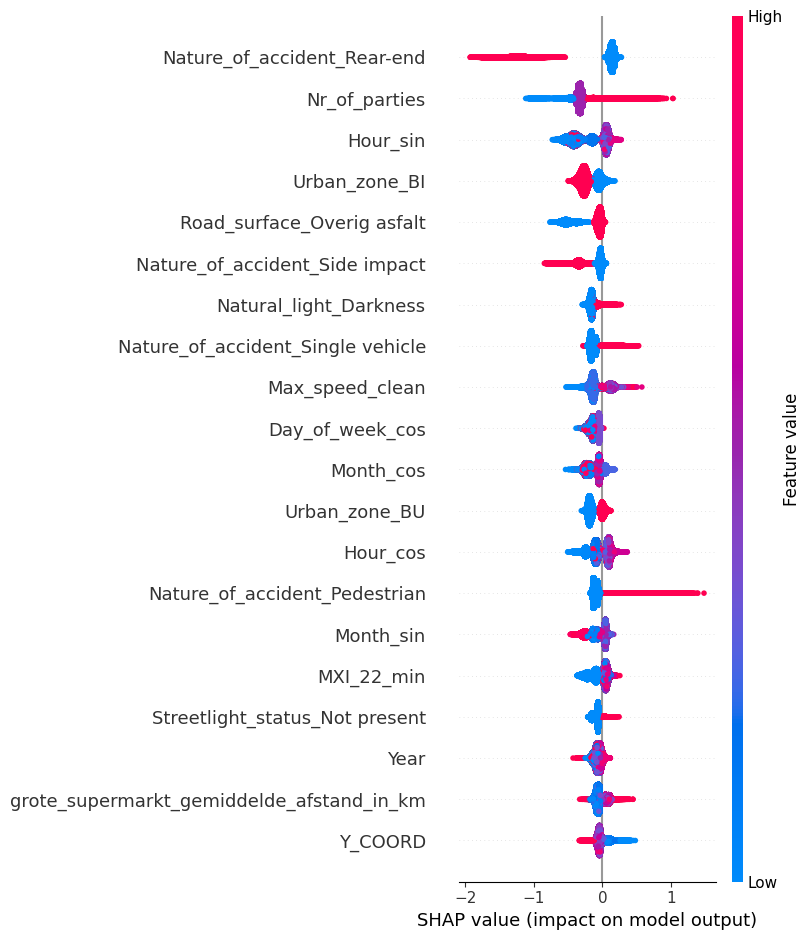


=== SHAP Beeswarm Plot for class 'LET' ===


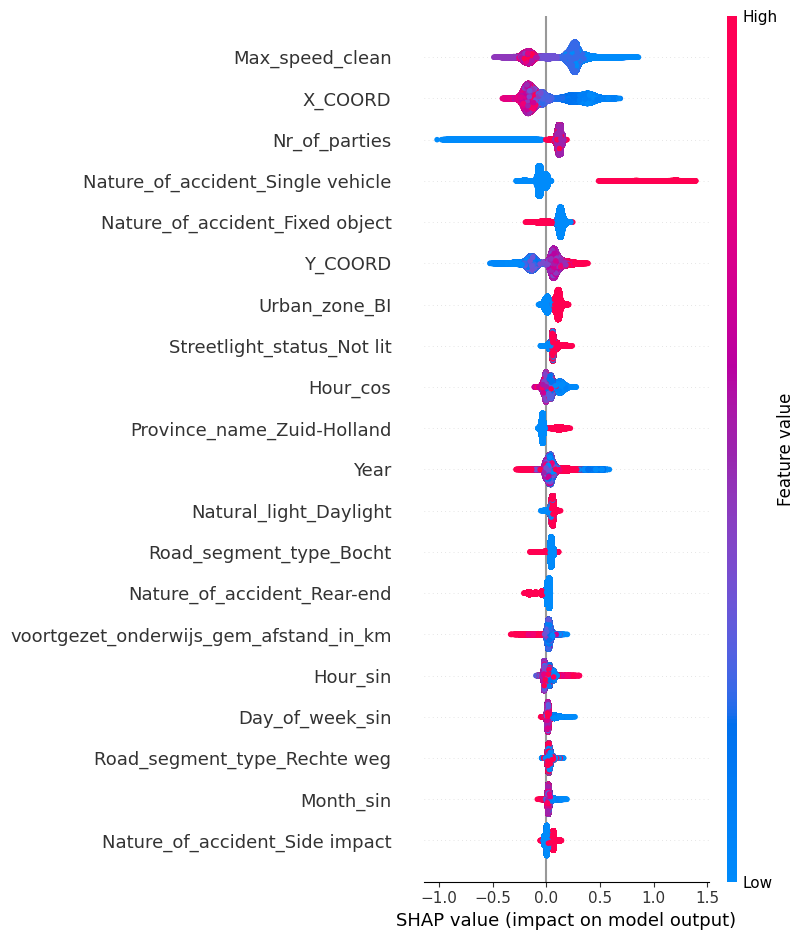


=== SHAP Beeswarm Plot for class 'UMS' ===


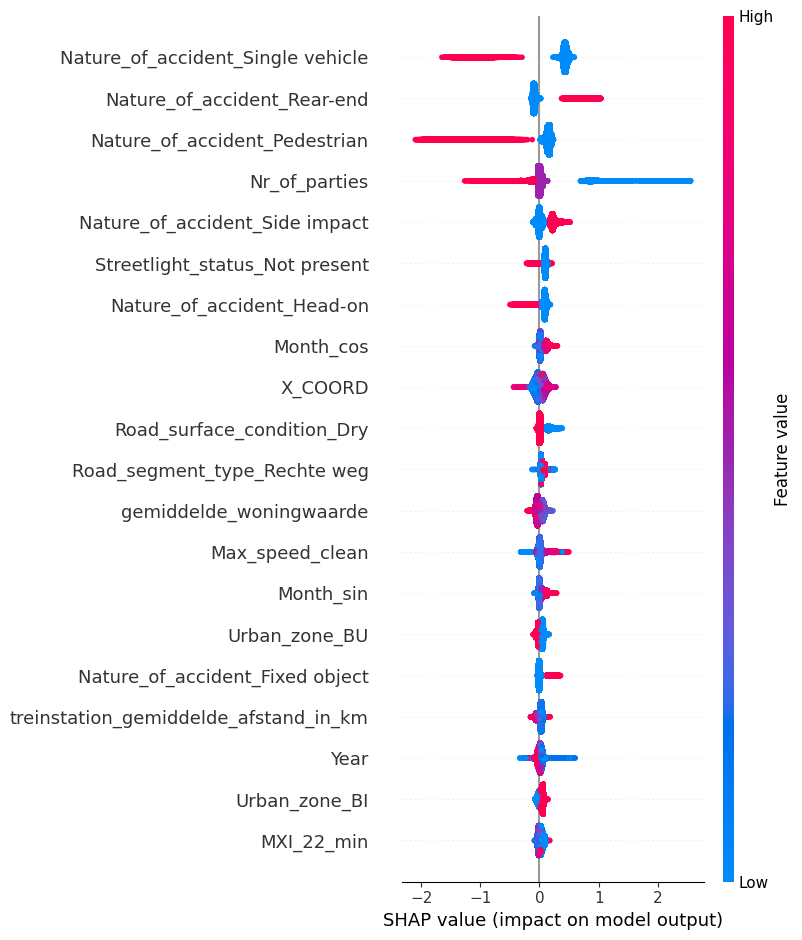

In [24]:
# class labels — match your class order
class_names = ['DOD', 'LET', 'UMS']

# Plot SHAP summary beeswarm per class
for i, class_name in enumerate(class_names):
    print(f"\n=== SHAP Beeswarm Plot for class '{class_name}' ===")
    shap.summary_plot(
        shap_values[:, :, i],         # SHAP values for class i
        features=X_100m_df,           # DataFrame with samples
        feature_names=feature_names_100m,
        show=True
    )



In [26]:
import matplotlib.pyplot as plt

# Class labels — match your class order
class_names = ['DOD', 'LET', 'UMS']

# Plot and save SHAP summary beeswarm per class
for i, class_name in enumerate(class_names):
    print(f"\n=== SHAP Beeswarm Plot for class '{class_name}' ===")
    
    shap.summary_plot(
        shap_values[:, :, i],         # SHAP values for class i
        features=X_100m_df,           # DataFrame with samples
        feature_names=feature_names_100m,
        show=False                    # Don't display yet
    )
    
    # Save the current figure
    plt.tight_layout()
    plt.savefig(f"shap_beeswarm_{class_name}.png", dpi=300)
    plt.close()  # Close the plot to avoid overlapping figures



=== SHAP Beeswarm Plot for class 'DOD' ===

=== SHAP Beeswarm Plot for class 'LET' ===

=== SHAP Beeswarm Plot for class 'UMS' ===


In [ ]:
import shap
import pandas as pd

# Step 1: Extract trained LightGBM model from pipeline
lgbm_model_100m = model_100m.named_steps['lgbm']

# Step 2: Build aligned test DataFrame using model's features
feature_names = lgbm_model_100m.booster_.feature_name()
X_100m_df = pd.DataFrame(X_test_100m_encoded, columns=feature_names)

# Step 3: Create TreeExplainer with default settings (model_output="raw")
explainer = shap.TreeExplainer(lgbm_model_100m)

# Step 4: Compute SHAP values (should return a list of 3 arrays, one per class)
shap_values = explainer.shap_values(X_100m_df)

# Step 5: Confirm shapes
print("✅ SHAP values shape per class:", [sv.shape for sv in shap_values])
print("✅ X_test shape:", X_100m_df.shape)

# Step 6: Plot summary per class
class_names = ['DOD', 'LET', 'UMS']
for i, class_name in enumerate(class_names):
    print(f"\n=== SHAP Summary for class '{class_name}' ===")
    shap.summary_plot(shap_values[i], X_100m_df, show=True)
